In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from keras.layers import Input, Dense, Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam



import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [2]:
df_crop = pd.read_csv('../input/crop-recommendation-dataset/Crop_recommendation.csv')
df_crop.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
df_crop.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [4]:
df_crop['label'].nunique()

22

In [5]:
df_crop['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [6]:
df_crop.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [7]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [8]:
df_crop['label'].value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: label, dtype: int64

In [9]:
label_encode = LabelEncoder()

df_crop['label'] = label_encode.fit_transform(df_crop['label'])
crop_category = {index : label for index, label in enumerate(label_encode.classes_)}
crop_category
df_crop

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,20
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,5
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,5
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,5
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,5


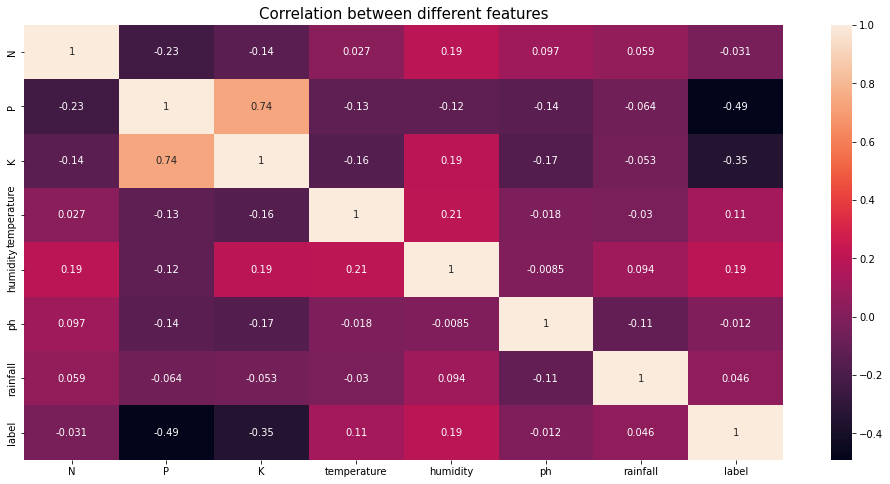

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(17, 8))
sns.heatmap(df_crop.corr(), annot=True )
plt.title('Correlation between different features', fontsize = 15, c='black')
plt.show()

In [11]:
X = df_crop.drop('label', axis = 1)
y = df_crop['label']
crop_summary = pd.pivot_table(df_crop,index=['label'],aggfunc='mean')
crop_summary.head()
X = df_crop.drop('label', axis = 1)
y = df_crop['label']
X = X.to_numpy()
X = X.reshape(X.shape[0], X.shape[1], 1)
X.shape
y = y.to_numpy()
y = y.reshape(y.shape[0], 1)
y.shape
print('Loading data...')
X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.80)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

# Define the hyperparameter search space for the genetic algorithm
search_space = {
    'n_layers': randint(1, 3),
    'n_units': randint(32, 128),
    'dropout_rate': np.arange(0.1, 0.5, 0.1),
    'batch_size': [32, 64, 128],
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'n_epochs': randint(10, 100),
    'optimizer': ['adam', 'rmsprop']
}

def create_model(n_layers, n_units, dropout_rate, learning_rate, optimizer):
    # Define the architecture of the LSTM model
    model = Sequential()
    # Add LSTM layers with dropout regularization
    for i in range(n_layers):
        if i == 0:
            # First layer should specify input shape
            model.add(LSTM(units=n_units, return_sequences=True, input_shape=(None, 1)))
        elif i == n_layers - 1:
            # Last layer should not return sequences
            model.add(LSTM(units=n_units, dropout=dropout_rate))
        else:
            # Intermediate layers should return sequences
            model.add(LSTM(units=n_units, return_sequences=True, dropout=dropout_rate))
        model.add(Dropout(rate=dropout_rate))
    
    # Add a dense layer to output a single value
    model.add(Dense(units=1))
    
    # Compile the model with the specified optimizer and learning rate
    optimizer = Adam(learning_rate=learning_rate)

#     optimizer = getattr(keras.optimizers, optimizer)(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = 'accuracy')
    
    return model

Loading data...
1760 train sequences
440 test sequences


In [12]:
# n_layers = 2
# n_units = 50
# dropout_rate = 0.2
# learning_rate = 0.01
# optimizer = 'adam'

# # Create the model
# model = create_model(n_layers, n_units, dropout_rate, learning_rate, optimizer)

# # Train the model
# epochs = 100
# history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate the model
# score = model.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score)

data = np.random.randn(1000, 10, 1)
labels = np.random.randn(1000, 1)

# Set hyperparameters
n_layers = 2
n_units = 64
dropout_rate = 0.2
learning_rate = 0.001
optimizer = 'Adam'

# Create the model
model = create_model(n_layers, n_units, dropout_rate, learning_rate, optimizer)

# Train the model
epochs = 10
batch_size = 32
model.fit(data, labels, epochs=epochs, batch_size=batch_size)

# Make a prediction
test_data = np.random.randn(1, 10, 1)
prediction = model.predict(test_data)
print(prediction)

Epoch 1/10
32/32 [==============================] - 5s 5ms/step - loss: 1.0115 - accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0141 - accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0118 - accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0102 - accuracy: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0102 - accuracy: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0076 - accuracy: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0082 - accuracy: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0089 - accuracy: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0123 - accuracy: 0.0000e+00
Epoch 10/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0102 - 

In [13]:
n_layers = 3
n_units = 64
dropout_rate = 0.2
learning_rate = 0.001
optimizer = 'Adam'

# Train the model with the new hyperparameters
model = create_model(n_layers, n_units, dropout_rate, learning_rate, optimizer)
history = model.fit(X_train, y_train, epochs=50, batch_size=64)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)

# Print the test loss
print('Test loss:', test_loss)

# Update the hyperparameters for the final model
n_layers = 2
n_units = 128
dropout_rate = 0.3
learning_rate = 0.0005
optimizer = 'Adamax'

# Create the final model with the updated hyperparameters
final_model = create_model(n_layers, n_units, dropout_rate, learning_rate, optimizer)


Epoch 1/50
28/28 [==============================] - 4s 6ms/step - loss: 85.1498 - accuracy: 0.0466
Epoch 2/50
28/28 [==============================] - 0s 6ms/step - loss: 41.4897 - accuracy: 0.0460
Epoch 3/50
28/28 [==============================] - 0s 6ms/step - loss: 41.9083 - accuracy: 0.0460
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 41.6731 - accuracy: 0.0460
Epoch 5/50
28/28 [==============================] - 0s 6ms/step - loss: 41.8811 - accuracy: 0.0460
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 41.9086 - accuracy: 0.0460
Epoch 7/50
28/28 [==============================] - 0s 6ms/step - loss: 41.7226 - accuracy: 0.0460
Epoch 8/50
28/28 [==============================] - 0s 6ms/step - loss: 41.1988 - accuracy: 0.0460
Epoch 9/50
28/28 [==============================] - 0s 6ms/step - loss: 41.3857 - accuracy: 0.0460
Epoch 10/50
28/28 [==============================] - 0s 6ms/step - loss: 41.0285 - accuracy: 0.0460
Epoch 11/

14/14 [==============================] - 0s 3ms/step - loss: 3.4947 - accuracy: 0.0432
Test loss: [3.494715452194214, 0.04318181797862053]


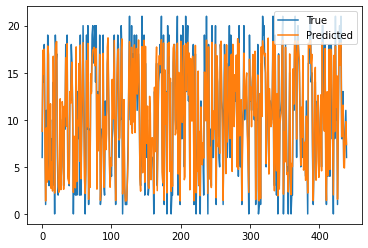

In [14]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)

# Print the test loss
print('Test loss:', test_loss)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the predicted values against the true values
import matplotlib.pyplot as plt

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [15]:
final_model = create_model(n_layers, n_units, dropout_rate, learning_rate, optimizer)


In [16]:
# Train the model with the new hyperparameters
model = create_model(n_layers, n_units, dropout_rate, learning_rate, optimizer)
history = model.fit(X_train, y_train, epochs=50, batch_size=64)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)

# Print the test loss
print('Test loss:', test_loss)

# Update the hyperparameters for the final model
n_layers = 2
n_units = 128
dropout_rate = 0.3
learning_rate = 0.0005
optimizer = 'Adamax'

# Create the final model with the updated hyperparameters
final_model = create_model(n_layers, n_units, dropout_rate, learning_rate, optimizer)


Epoch 1/50
28/28 [==============================] - 3s 5ms/step - loss: 82.4391 - accuracy: 0.0460
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 41.7209 - accuracy: 0.0460
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 41.0050 - accuracy: 0.0460
Epoch 4/50
28/28 [==============================] - 0s 5ms/step - loss: 40.8409 - accuracy: 0.0460
Epoch 5/50
28/28 [==============================] - 0s 5ms/step - loss: 40.1984 - accuracy: 0.0460
Epoch 6/50
28/28 [==============================] - 0s 5ms/step - loss: 39.3070 - accuracy: 0.0460
Epoch 7/50
28/28 [==============================] - 0s 5ms/step - loss: 38.3623 - accuracy: 0.0460
Epoch 8/50
28/28 [==============================] - 0s 5ms/step - loss: 36.0351 - accuracy: 0.0460
Epoch 9/50
28/28 [==============================] - 0s 5ms/step - loss: 31.1074 - accuracy: 0.0460
Epoch 10/50
28/28 [==============================] - 0s 5ms/step - loss: 25.1027 - accuracy: 0.0460
Epoch 11/

14/14 [==============================] - 0s 3ms/step - loss: 3.5081 - accuracy: 0.0568
Test loss: [3.508068323135376, 0.05681818351149559]


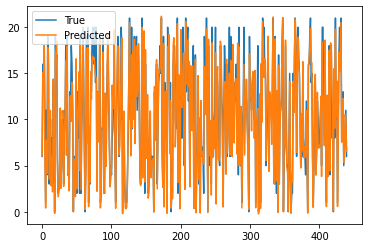

In [17]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)

# Print the test loss
print('Test loss:', test_loss)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the predicted values against the true values
import matplotlib.pyplot as plt

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()